This is motivated by the example given in the book _Probabilistic Programming and Bayesian Methods for Hackers_.
https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers

We performed classification on a data set that recorded the failures of O-ring on space shuttle. Each row in the  data set (1D) records the external temperature (feature) and whether the O-ring was damaged or not (response).



In [45]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

import pymc3 as pm
import theano.tensor as tt

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

In [2]:
column_names = ['date', 'temperature', 'damaged']
column_types = {'date': str, 'temperature': float, 'damaged': float}
df = pd.read_csv('challenger_data.csv', skiprows=1, names=column_names)
df = df[(df['damaged']!='Challenger Accident') &(~pd.isnull(df['damaged']))]

df['temperature'] = df['temperature'].astype(float)
df['damaged'] = df['damaged'].astype(int)

In [3]:
df.sample(7)

,date,temperature,damaged
19,8/27/85,76.0,0
11,8/30/84,70.0,1
10,04/06/1984,63.0,1
22,11/26/85,76.0,0
1,11/12/1981,70.0,1
23,01/12/1986,58.0,1
16,4/29/85,75.0,0


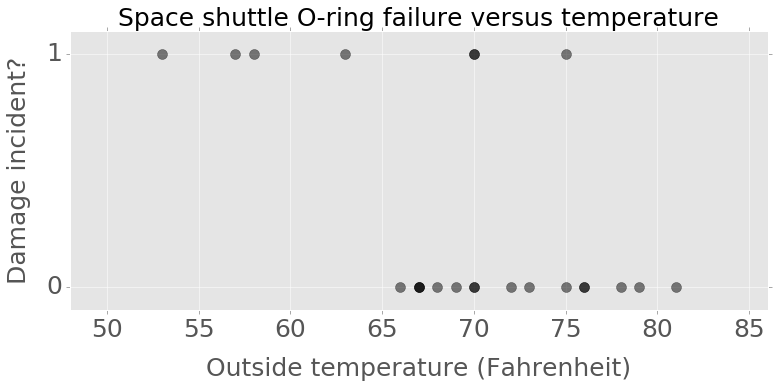

In [4]:
FONTSIZE = 25
plt.close('all')
fig, ax = plt.subplots(1, figsize=(12.5, 5))

ax.scatter(df['temperature'], df['damaged'], s=100, alpha=0.5, color='k')
yticks = ax.set_yticks([0, 1])
ax.set_xlabel('Outside temperature (Fahrenheit)', fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel('Damage incident?', fontsize=FONTSIZE, labelpad=15)
ax.set_title('Space shuttle O-ring failure versus temperature', fontsize=FONTSIZE)

ax.set_xlim(df['temperature'].min()-5, df['temperature'].max()+5)
ax.set_ylim([-0.1, 1.1])

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(FONTSIZE)
    tick.label.set_rotation(0)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(FONTSIZE)
    tick.label.set_rotation(0) 

From the above plot, it clearly shows that the probability of failure goes up as temperature becomes lower. 
We will use logistic regression to build a classifier to predict of the O-ring will be damaged.

In [54]:
# We use 5-fold cross-validation to determine the magnitude of regularization
# smaller values mean stronger regularization
dof_for_complexity = [1.0, 10.0, 100.0, 1000.0]
best_c = None
best_score = 0
fitted_coeffs = []
for c in dof_for_complexity:
    clf = LogisticRegression(C=c)
    clf.fit(df[['temperature']].values, df['damaged'].values)
    fitted_coeffs.append((clf.intercept_, clf.coef_))
    scores = cross_val_score(clf, df[['temperature']].values, df['damaged'].values, cv=5)
    mean_score = scores.mean()
    if mean_score > best_score:
        best_score = mean_score
        best_c = c

best_clf = LogisticRegression(C=best_c)
best_clf.fit(df[['temperature']].values, df['damaged'].values)

lg_beta0 = best_clf.intercept_[0]
lg_beta1 = best_clf.coef_[0][0]

print(r'beta_0={0:.4f}, beta_1={1:.4f}, score: {2:.3f}'.format(lg_beta0, lg_beta1, best_score))

beta_0=10.5292, beta_1=-0.1662, score: 0.837


In [21]:
def logistic_1d(x, beta0, beta1):
    return 1.0/(1.0 + np.exp(-(beta0+beta1*x)))

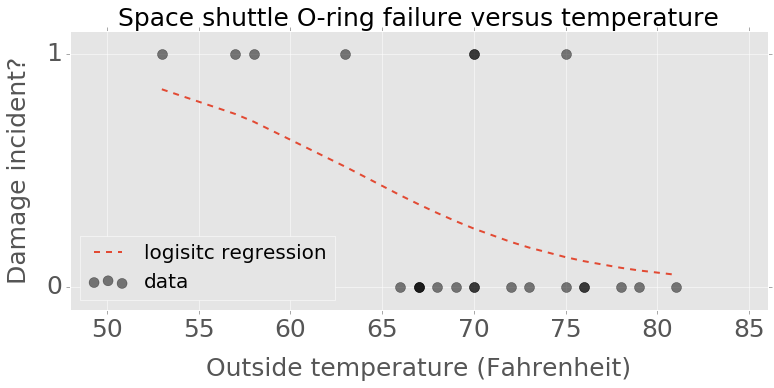

In [55]:
ts = np.sort(df['temperature'].values)
xs = logistic_1d(ts, lg_beta0, lg_beta1)

FONTSIZE = 25
plt.close('all')
fig, ax = plt.subplots(1, figsize=(12.5, 5))

ax.scatter(df['temperature'], df['damaged'], s=100, alpha=0.5, color='k', label='data')
ax.plot(ts, xs, ls='--', lw=2, label='logisitc regression')
yticks = ax.set_yticks([0, 1])
ax.set_xlabel('Outside temperature (Fahrenheit)', fontsize=FONTSIZE, labelpad=15)
ax.set_ylabel('Damage incident?', fontsize=FONTSIZE, labelpad=15)
ax.set_title('Space shuttle O-ring failure versus temperature', fontsize=FONTSIZE)

ax.set_xlim(df['temperature'].min()-5, df['temperature'].max()+5)
ax.set_ylim([-0.1, 1.1])

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(FONTSIZE)
    tick.label.set_rotation(0)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(FONTSIZE)
    tick.label.set_rotation(0) 
    
ax.legend(loc=3, fontsize=FONTSIZE*0.8)    

Next, we use PyMC on the same data set to perform Bayesian logistic regression

We will assume uninformative Gaussian priors for beta_0 and beta_1, and model the occurrences of failures as Bernoulli random variable of probability p, where p is specified by the logistic (sigmoid) function of parameters (beta0, beta1).


In [47]:
temperatures = df['temperature'].values
incidents = df['damaged'].values
with pm.Model() as model:
    beta0 = pm.Normal('beta0', mu=0, tau=0.001, testval=0)
    beta1 = pm.Normal('beta1', mu=0, tau=0.001, testval=0)    
    p = pm.Deterministic('p', 1.0/(1.0 + tt.exp(-(beta0 + beta1*temperatures))))
    
    observed = pm.Bernoulli('observed_incidents', p, observed=incidents)
    
with model:
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(150000, step=step, start=start)
    burned_trace = trace[50000:]    

 [-----------------100%-----------------] 150000 of 150000 complete in 17.7 sec

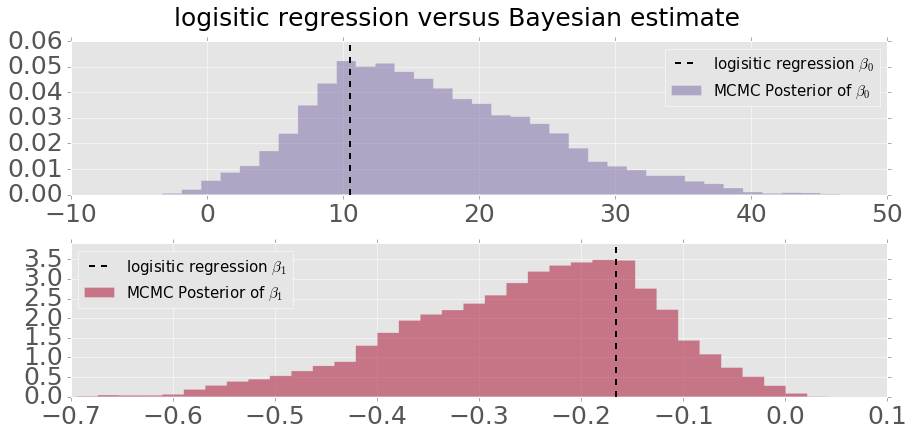

In [70]:
beta0_samples = burned_trace['beta0']
beta1_samples = burned_trace['beta1']

plt.close('all')

fig = plt.figure(figsize=(12.5, 6))
gs = matplotlib.gridspec.GridSpec(2, 1)

ax = plt.subplot(gs[0, 0]) 
h1 = ax.hist(beta0_samples, histtype='stepfilled', color="#7A68A6",
             bins=35, normed=True, alpha=0.5, label=r'MCMC Posterior of $\beta_0$')
ax.axvline(lg_beta0, 0, 1, label=r'logisitic regression $\beta_0$', lw=2, ls='--', color='k')
ax.legend(loc=1, fontsize=FONTSIZE*0.6)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(FONTSIZE)
    tick.label.set_rotation(0)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(FONTSIZE)
    tick.label.set_rotation(0)     

ax = plt.subplot(gs[1, 0]) 
h2 = ax.hist(beta1_samples, histtype='stepfilled', color="#A60628",
             bins=35, normed=True, alpha=0.5, label=r'MCMC Posterior of $\beta_1$')
ax.axvline(lg_beta1, 0, 1.0, label=r'logisitic regression $\beta_1$', lw=2, ls='--', color='k')
ax.set_ylim(0, 3.9)
ax.legend(loc=2, fontsize=FONTSIZE*0.6)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(FONTSIZE)
    tick.label.set_rotation(0)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(FONTSIZE)
    tick.label.set_rotation(0) 

plt.tight_layout(pad=0, w_pad=1.0, h_pad=2.0)
fig.suptitle('logisitic regression versus Bayesian estimate', fontsize=FONTSIZE)
plt.subplots_adjust(top=0.9)

How about the prediction for the accident day, when the temperature was 31 ?

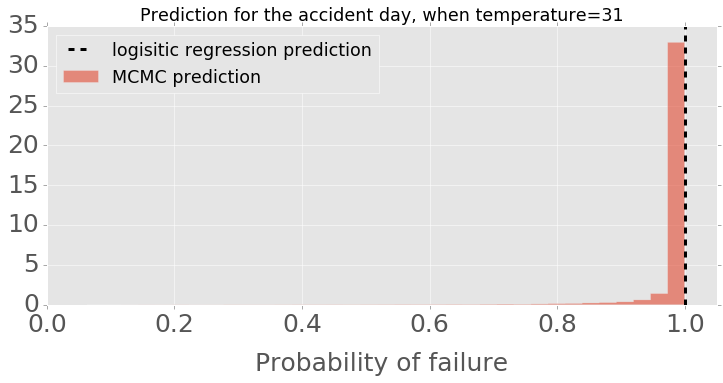

In [98]:
accident_day_temp = np.array([[31],])
lg_predict = best_clf.predict(accident_day_temp)
mcmc_predict = logistic_1d(accident_day_temp, beta0_samples, beta1_samples)[0][:]

FONTSIZE = 25
plt.close('all')
fig, ax = plt.subplots(1, figsize=(12, 5))
ax.hist(mcmc_predict, histtype='stepfilled', bins=35, alpha=0.6, normed=True, label='MCMC prediction')
ax.axvline(lg_predict, 0, 10.0, color='k', lw=3, ls='--', label='logisitic regression prediction')
ax.set_xlabel('Probability of failure', fontsize=FONTSIZE, labelpad=15)
ax.set_xlim(0, 1.05)
ax.legend(loc=2, fontsize=FONTSIZE*0.7)

ax.set_title('Prediction for the accident day, when temperature=31', fontsize=FONTSIZE*0.7)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(FONTSIZE)
    tick.label.set_rotation(0)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(FONTSIZE)
    tick.label.set_rotation(0) 